# Introduction to Artificial Neural Networks with Keras

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Perceptrons

In [3]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [4]:
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

# we set `max_iter` and `tol` explicitly to avoid warnings 
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

In [11]:
per_clf.coef_

array([[-1.4, -2.2]])

In [12]:
per_clf.intercept_

array([4.])

In [68]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )

In [78]:
x0.shape

(200, 500)

In [70]:
X_new = np.stack([x0.flatten(), x1.flatten()], axis=1)
X_new

array([[0.        , 0.        ],
       [0.01002004, 0.        ],
       [0.02004008, 0.        ],
       ...,
       [4.97995992, 2.        ],
       [4.98997996, 2.        ],
       [5.        , 2.        ]])

In [72]:
y_predict = per_clf.predict(X_new)
y_predict

array([1, 1, 1, ..., 0, 0, 0])

In [73]:
zz = y_predict.reshape(x0.shape)
zz

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
from matplotlib.colors import ListedColormap

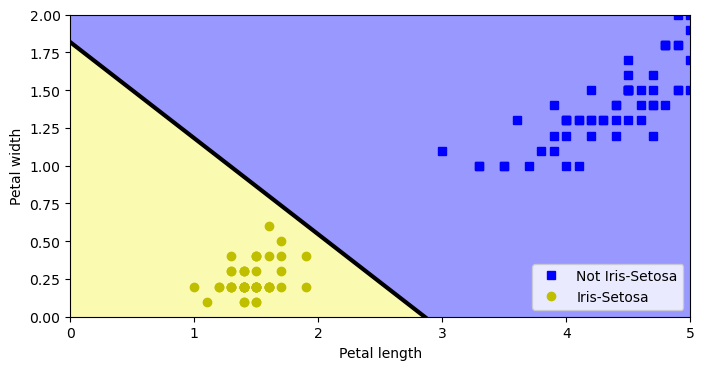

In [48]:
_, ax = plt.subplots(figsize=(8, 4), dpi=100)

ax.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
ax.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")

ax.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b],
        "k-",
        linewidth=3)

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

ax.contourf(x0, x1, zz, cmap=custom_cmap)
ax.set(xlabel="Petal length", ylabel="Petal width")
ax.legend(loc="lower right")

xmin, xmax, ymin, ymax = axes
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.show()

# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

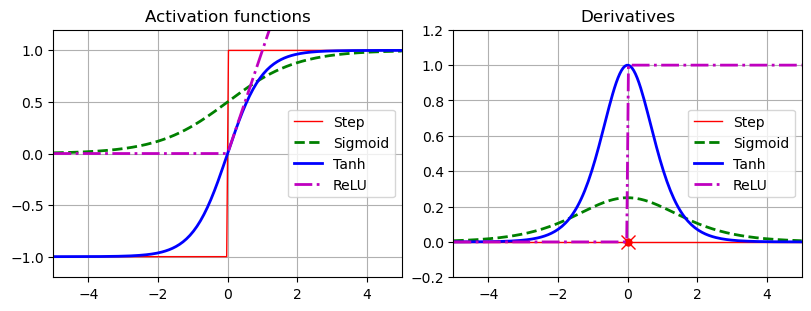

In [17]:
z = np.linspace(-5, 5, 200)

_, axes = plt.subplots(1,
                       2,
                       figsize=(8, 3),
                       dpi=100,
                       sharex=True,
                       constrained_layout=True)

axes[0].plot(z, np.sign(z), "r-", linewidth=1, label="Step")
axes[0].plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
axes[0].plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
axes[0].plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
axes[0].grid(1)
axes[0].legend(loc="center right", fontsize='medium')
axes[0].set(title="Activation functions", xlim=[-5, 5], ylim=[-1.2, 1.2])

axes[1].plot(0, 0, "ro", markersize=5)
axes[1].plot(0, 0, "rx", markersize=10)
axes[1].plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
axes[1].plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
axes[1].plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
axes[1].plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
axes[1].grid(1)
axes[1].legend(loc="center right", fontsize='medium')
axes[1].set(title="Derivatives", ylim=[-0.2, 1.2])
plt.show()

In [19]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

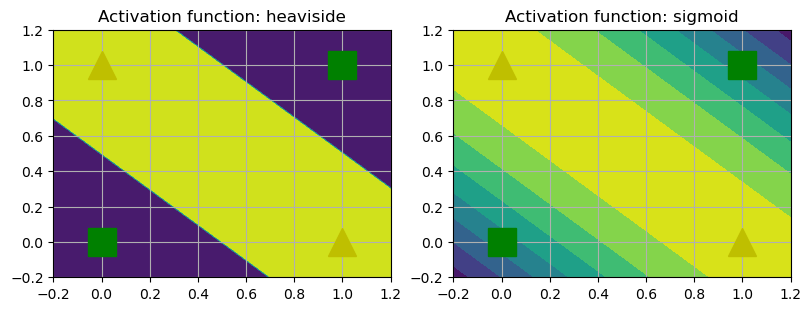

In [27]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

_, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100, constrained_layout=True)

z = [z1, z2]
funcs = ['heaviside', 'sigmoid']

for ind, ax in enumerate(axes):

    ax.contourf(x1, x2, z[ind])
    ax.plot([0, 1], [0, 1], "gs", markersize=20)
    ax.plot([0, 1], [1, 0], "y^", markersize=20)
    ax.set(title=f"Activation function: {funcs[ind]}")
    ax.grid(1)


# Building an Image Classifier

In [30]:
import tensorflow as tf
from tensorflow import keras

In [31]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [23]:
X_train_full.shape

(60000, 28, 28)

In [94]:
# Each pixel intensity is represented as a byte (0 to 255)
X_train_full.dtype

dtype('uint8')

In [32]:
# Let's split the full training set into a validation set and a (smaller) training set. 
# We also scale the pixel intensities down to the 0-1 range 
# and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

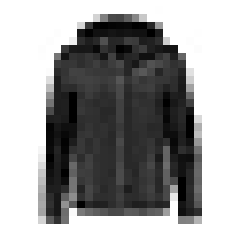

In [33]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [26]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [34]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt",
    "Sneaker", "Bag", "Ankle boot"
]


In [28]:
class_names[y_train[0]]

'Coat'

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

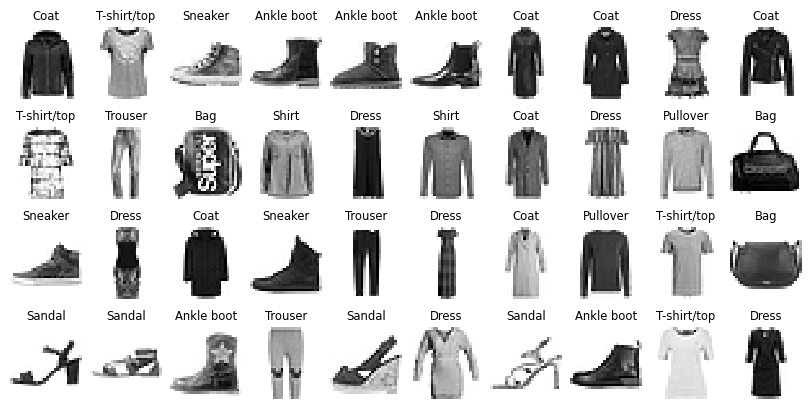

In [81]:
_, axes = plt.subplots(4,
                       10,
                       figsize=(8, 4),
                       dpi=100,
                       constrained_layout=True)

for ind, ax in enumerate(axes.flatten()):

    ax.imshow(X_train[ind], cmap="binary", interpolation="nearest")
    ax.axis('off')
    ax.set_title(class_names[y_train[ind]], fontsize='small')

plt.show()

In [82]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2021-08-21 22:20:09.141473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [85]:
model.layers

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [87]:
import pydot

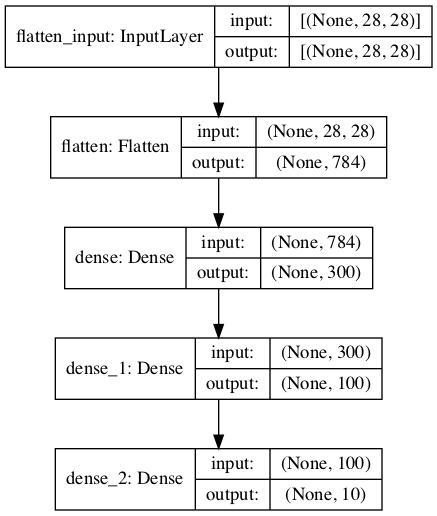

In [88]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [89]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [90]:
model.get_layer(hidden1.name) is hidden1

True

In [91]:
weights, biases = hidden1.get_weights()

In [92]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [41]:
weights.shape

(784, 300)

In [42]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
biases.shape

(300,)

In [93]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [96]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0188 - accuracy: 0.6805 - val_loss: 0.5218 - val_accuracy: 0.8210
Epoch 2/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5028 - accuracy: 0.8260 - val_loss: 0.4354 - val_accuracy: 0.8522
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4484 - accuracy: 0.8425 - val_loss: 0.5316 - val_accuracy: 0.7988
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4207 - accuracy: 0.8525 - val_loss: 0.3914 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4060 - accuracy: 0.8582 - val_loss: 0.3745 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3751 - accuracy: 0.8679 - val_loss: 0.3707 - val_accuracy: 0.8728
Epoch 7/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3649 - accuracy: 0.8710 - val_loss: 0.3630 - val_accuracy

In [97]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [99]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [105]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

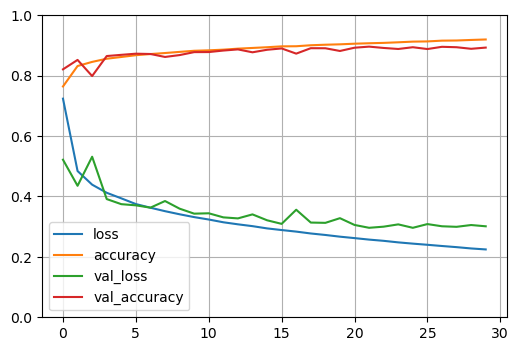

In [111]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in history.history.keys():
    ax.plot(history.history.get(i), label=i)
    ax.legend()

ax.set(ylim=(0, 1))
ax.grid(1)

In [112]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3353 - accuracy: 0.8820


[0.3352515995502472, 0.8820000290870667]

In [113]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [115]:
model.predict(X_new)

array([[4.1024000e-06, 4.2761562e-07, 7.7352219e-05, 8.9763398e-06,
        3.7400682e-06, 1.1412925e-02, 7.8980111e-06, 2.8233122e-02,
        7.8887114e-04, 9.5946258e-01],
       [1.1116678e-05, 3.6214793e-08, 9.8210180e-01, 1.5544003e-08,
        1.7581107e-02, 1.9387754e-11, 3.0586790e-04, 1.2198677e-11,
        7.3210291e-09, 3.6714097e-11],
       [2.8578486e-06, 9.9999654e-01, 2.0927594e-08, 4.1734179e-07,
        1.2935442e-07, 1.8845613e-13, 5.0816507e-10, 4.4625967e-13,
        8.3641147e-09, 2.6737662e-12]], dtype=float32)

In [114]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [116]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

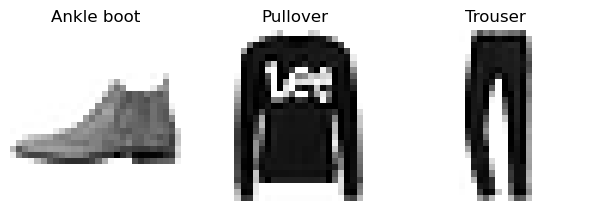

In [121]:
_, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=100, constrained_layout=True)

for ind, (ax, image) in enumerate(zip(axes.flatten(), X_new)):
    ax.imshow(image, cmap="binary", interpolation="nearest")
    ax.axis('off')
    ax.set(title=class_names[y_test[ind]])

plt.show()

# Regression MLP

In [122]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [123]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target,
                                                              random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [124]:
np.random.seed(42)
tf.random.set_seed(42)

In [125]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.2656 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7413 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6604 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6245 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5770 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5609 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5500 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5200 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5051 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4910 - val_loss: 0.4656

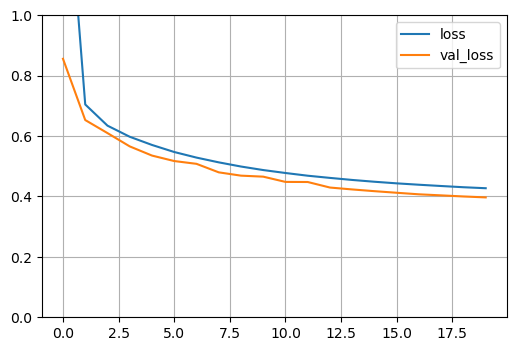

In [126]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in history.history.keys():
    ax.plot(history.history.get(i), label=i)
    ax.legend()

ax.set(ylim=(0, 1))
ax.grid(1)

In [52]:
y_pred

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

# Functional API

In [127]:
np.random.seed(42)
tf.random.set_seed(42)

In [131]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [129]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [132]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.6311 - val_loss: 0.8798
Epoch 2/20
363/363 [==============================] - 2s 4ms/step - loss: 0.7247 - val_loss: 0.6420
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6447 - val_loss: 0.5891
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6127 - val_loss: 0.5455
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5640 - val_loss: 0.5409
Epoch 6/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5332 - val_loss: 0.4903
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5296 - val_loss: 0.4728
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5028 - val_loss: 0.5017
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4835 - val_loss: 0.4511
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4739 - val_loss: 0.4330

In [133]:
np.random.seed(42)
tf.random.set_seed(42)

In [134]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [135]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B),
                    y_train,
                    epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 3.1941 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7247 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6176 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5799 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5409 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5173 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5186 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4977 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4765 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4676 - val_loss: 0.4315

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [136]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [137]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [138]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 4s 4ms/step - loss: 3.2165 - main_output_loss: 3.0213 - aux_output_loss: 4.9724 - val_loss: 1.5430 - val_main_output_loss: 0.9144 - val_aux_output_loss: 7.2005
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 1.0694 - main_output_loss: 0.8370 - aux_output_loss: 3.1602 - val_loss: 1.3118 - val_main_output_loss: 0.6824 - val_aux_output_loss: 6.9755
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.8493 - main_output_loss: 0.6993 - aux_output_loss: 2.1995 - val_loss: 1.2622 - val_main_output_loss: 0.6458 - val_aux_output_loss: 6.8096
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7420 - main_output_loss: 0.6330 - aux_output_loss: 1.7228 - val_loss: 1.2022 - val_main_output_loss: 0.6136 - val_aux_output_loss: 6.5002
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6819 - main_output_loss: 0.5849 - aux_output_loss: 1.5553 - val_loss

In [139]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 2ms/step - loss: 0.4822 - main_output_loss: 0.4278 - aux_output_loss: 0.9714


# The subclassing API

In [140]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [141]:
model.compile(loss="mse",
              loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(
    (X_train_A, X_train_B), (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B),
                                                 (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 3.8009 - output_1_loss: 3.6761 - output_2_loss: 4.9248 - val_loss: 1.3330 - val_output_1_loss: 1.1116 - val_output_2_loss: 3.3258
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 1.0800 - output_1_loss: 0.9053 - output_2_loss: 2.6519 - val_loss: 0.9691 - val_output_1_loss: 0.7378 - val_output_2_loss: 3.0513
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.8149 - output_1_loss: 0.6948 - output_2_loss: 1.8967 - val_loss: 0.8643 - val_output_1_loss: 0.6389 - val_output_2_loss: 2.8933
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.7127 - output_1_loss: 0.6208 - output_2_loss: 1.5397 - val_loss: 0.7715 - val_output_1_loss: 0.5502 - val_output_2_loss: 2.7633
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6487 - output_1_loss: 0.5675 - output_2_loss: 1.3799 - val_loss: 0.7158 - val_output_1_loss: 0.5121 - val_ou

# Saving and Restoring

In [142]:
np.random.seed(42)
tf.random.set_seed(42)

In [143]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [144]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 2s 4ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4382


In [146]:
path = "../data/101/my_keras_model.h5"
# model.save(path)
model = keras.models.load_model(path)

In [147]:
model.predict(X_new)

array([[0.5400237],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [148]:
# model.save_weights("../data/101/my_keras_weights.ckpt")
model.load_weights("../data/101/my_keras_weights.ckpt")

# Using Callbacks during Training

In [149]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [150]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [151]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 3.3697 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6964 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6167 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5846 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5321 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5083 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5044 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4813 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4627 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 1s 2ms/step - loss: 0.4382


In [152]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4578 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4430 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4376 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4361 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4204 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4112 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4226 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4135 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4039 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4023 - val_lo

In [80]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [81]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 799us/step - loss: 0.3302 - val_loss: 0.3556

val/train: 1.08


# TensorBoard

In [157]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [158]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_08_21-23_12_25'

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [159]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [160]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

2021-08-21 23:12:47.859743: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-21 23:12:47.859769: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-21 23:12:47.864181: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/30
  1/363 [..............................] - ETA: 3:45 - loss: 5.6398

2021-08-21 23:12:48.618439: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-21 23:12:48.618459: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 73/363 [=====>........................] - ETA: 1s - loss: 4.2694

2021-08-21 23:12:48.633072: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-21 23:12:48.647082: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-21 23:12:48.732654: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2021_08_21-23_12_25/train/plugins/profile/2021_08_21_23_12_48
2021-08-21 23:12:48.734530: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2021_08_21-23_12_25/train/plugins/profile/2021_08_21_23_12_48/Xavier-Yang.local.trace.json.gz
2021-08-21 23:12:48.820675: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2021_08_21-23_12_25/train/plugins/profile/2021_08_21_23_12_48
2021-08-21 23:12:48.821110: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to ./my_logs/run_2021_08_

363/363 [==============================] - 3s 5ms/step - loss: 2.9582 - val_loss: 2.0712
Epoch 2/30
363/363 [==============================] - 2s 4ms/step - loss: 0.9108 - val_loss: 0.8041
Epoch 3/30
363/363 [==============================] - 2s 4ms/step - loss: 0.7265 - val_loss: 0.6115
Epoch 4/30
363/363 [==============================] - 2s 4ms/step - loss: 0.6651 - val_loss: 0.5678
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6010 - val_loss: 0.5300
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5627 - val_loss: 0.5024
Epoch 7/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5465 - val_loss: 0.4792
Epoch 8/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5081 - val_loss: 0.4531
Epoch 9/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4867 - val_loss: 0.4335
Epoch 10/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4703 - val_loss: 0.4188
Epoch 11/3

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [161]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [164]:
run_logdir2 = get_run_logdir()

In [165]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

2021-08-21 23:15:32.286059: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-21 23:15:32.286098: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-21 23:15:32.286141: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/30
  3/363 [..............................] - ETA: 17s - loss: 4.8988 

2021-08-21 23:15:33.160957: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-21 23:15:33.161012: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-21 23:15:33.193370: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-21 23:15:33.194543: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-21 23:15:33.199985: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2021_08_21-23_15_30/train/plugins/profile/2021_08_21_23_15_33
2021-08-21 23:15:33.200709: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2021_08_21-23_15_30/train/plugins/profile/2021_08_21_23_15_33/Xavier-Yang.local.trace.json.gz
2021-08-21 23:15:33.202232: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2

363/363 [==============================] - 3s 6ms/step - loss: 0.8197 - val_loss: 7.0999
Epoch 2/30
363/363 [==============================] - 1s 4ms/step - loss: 1.6902 - val_loss: 4.4362
Epoch 3/30
363/363 [==============================] - 1s 4ms/step - loss: 0.4785 - val_loss: 0.7658
Epoch 4/30
363/363 [==============================] - 2s 4ms/step - loss: 0.3769 - val_loss: 1.1458
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3762 - val_loss: 1.8901
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4009 - val_loss: 0.9325
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.3916 - val_loss: 0.3781
Epoch 8/30
363/363 [==============================] - 3s 9ms/step - loss: 0.3527 - val_loss: 0.3334
Epoch 9/30
363/363 [==============================] - 2s 4ms/step - loss: 0.3456 - val_loss: 0.3126
Epoch 10/30
363/363 [==============================] - 1s 4ms/step - loss: 0.3426 - val_loss: 0.3116
Epoch 11/3

In [163]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [153]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [154]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [155]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [156]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 1.5673 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 1.3216 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5972 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4985 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4608 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4410 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4463 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4283 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4139 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4107 - val_l

In [167]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 3ms/step - loss: 0.3409


In [168]:
y_pred = keras_reg.predict(X_new)

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

In [169]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [170]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg,
                                   param_distribs,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2)
rnd_search_cv.fit(X_train,
                  y_train,
                  epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 2s 6ms/step - loss: 1.6472 - val_loss: 1.7853
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 1.0140 - val_loss: 0.6444
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6038 - val_loss: 0.4448
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4934 - val_loss: 0.4170
Epoch 5/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4521 - val_loss: 0.4114
Epoch 6/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4335 - val_loss: 0.4134
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4638 - val_loss: 0.4113
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4422 - val_loss: 0.3996
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4226 - val_loss: 0.4094
Epoch 10/100
242/242 [========

In [101]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [102]:
rnd_search_cv.best_score_

-0.32039451599121094

In [103]:
rnd_search_cv.best_estimator_

In [104]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 436us/step - loss: 0.3029


-0.3028871417045593

In [105]:
model = rnd_search_cv.best_estimator_.model
model

In [106]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 446us/step - loss: 0.3029


0.3028871417045593

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

In [107]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [108]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [109]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [110]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

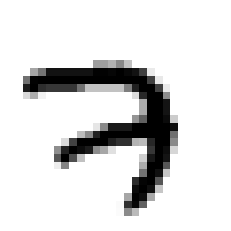

In [111]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [112]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [113]:
X_valid.shape

(5000, 28, 28)

In [114]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

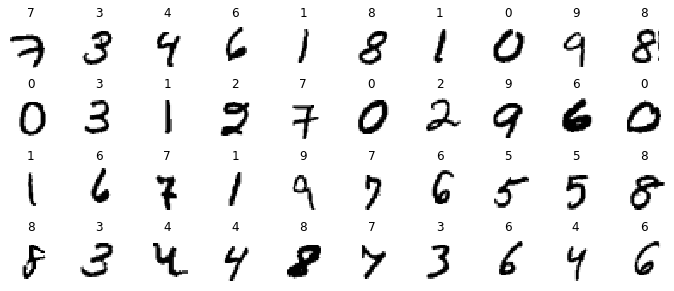

In [115]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        ax.set(title=y_train[index], fontsize='small')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [116]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [117]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [118]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [119]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [120]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 2s 1ms/step - loss: 4.6604 - accuracy: 0.4887 - val_loss: 2.3911 - val_accuracy: 0.1126


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

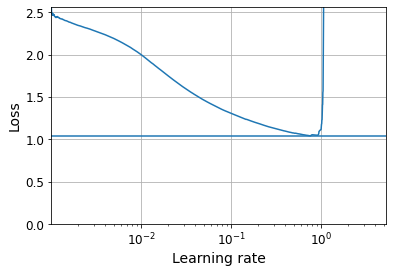

In [121]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
ax.set(xlim=[min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
ax.grid(1)
ax.set(xlabel="Learning rate")
ax.set(ylabel="Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [122]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [124]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

In [125]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [126]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4195 - accuracy: 0.8677 - val_loss: 0.0995 - val_accuracy: 0.9724
Epoch 2/100
1719/1719 [==============================] - 2s 882us/step - loss: 0.0941 - accuracy: 0.9698 - val_loss: 0.0913 - val_accuracy: 0.9746
Epoch 3/100
1719/1719 [==============================] - 1s 845us/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0785 - val_accuracy: 0.9772
Epoch 4/100
1719/1719 [==============================] - 2s 932us/step - loss: 0.0438 - accuracy: 0.9855 - val_loss: 0.0793 - val_accuracy: 0.9784
Epoch 5/100
1719/1719 [==============================] - 1s 832us/step - loss: 0.0348 - accuracy: 0.9888 - val_loss: 0.0724 - val_accuracy: 0.9812
Epoch 6/100
1719/1719 [==============================] - 1s 835us/step - loss: 0.0289 - accuracy: 0.9905 - val_loss: 0.0814 - val_accuracy: 0.9792
Epoch 7/100
1719/1719 [==============================] - 1s 868us/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0

In [127]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 701us/step - loss: 0.0804 - accuracy: 0.9806


[0.08043695986270905, 0.9805999994277954]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [128]:
%tensorboard --logdir=./my_mnist_logs --port=6006